# Quasi-continuous BN

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
from pylab import *
import matplotlib.pyplot as plt

aGrUM cannot (currently) deal with with continuous variables. However, a discrete variable with a large enough domain size is an approximation of such variables.

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

#nbr of states for quasi continuous variables. You can change the value 
#but be careful of the quadratic behavior of both memory and time complexity
#in this example.
minB,maxB=-3,3
minC,maxC=4,14
NB=300 

BN{nodes: 2, arcs: 1, domainSize: 600, dim: 602}


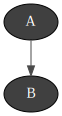

In [3]:
bn=gum.BayesNet("Quasi-Continuous")
bn.add(gum.LabelizedVariable("A","A binary variable",2))
bn.add(gum.NumericalDiscreteVariable("B","A range variable",minB,maxB,NB))
bn.addArc("A","B")
print(bn)
gnb.showBN(bn)

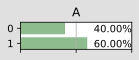

In [4]:
bn.cpt("A")[:]=[0.4, 0.6]
gnb.showProba(bn.cpt("A"))

## CPT for quasi-continuous variables (with parents)

Using python (and scipy), it is easy to find pdf for continuous variable


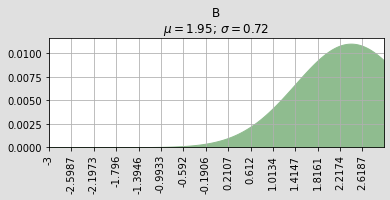
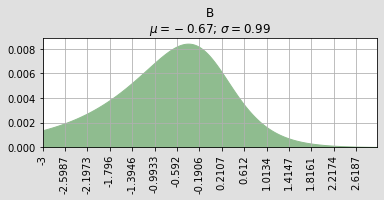

In [5]:
# we truncate a pdf, so we need to normalize 
def normalize(rv,vmin,vmax,size):
    pdf=rv.pdf(linspace(vmin,vmax,size))
    return (pdf/sum(pdf))

from scipy.stats import norm,genhyperbolic
p, a, b = 0.5, 1.5, -0.7
bn.cpt("B")[{'A':0}]=normalize(norm(2.41),minB,maxB,NB)
bn.cpt("B")[{'A':1}]=normalize(genhyperbolic(p,a,b),minB,maxB,NB)
gnb.flow.clear()
gnb.flow.add(gnb.getProba(bn.cpt("B").extract({"A":0})),caption="P(B|A=0)")
gnb.flow.add(gnb.getProba(bn.cpt("B").extract({"A":1})),caption="P(B|A=1)")
gnb.flow.display()

## Quasi-continuous inference (with no evidence)

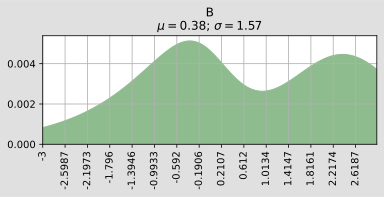

In [6]:
gnb.showPosterior(bn,target="B",evs={})

## Quasi-continuous variable with quasi-continuous parent

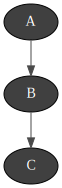

In [7]:
bn.add(gum.NumericalDiscreteVariable("C","Another quasi continuous variable",minC,maxC,NB))
bn.addArc("B","C")
gnb.showBN(bn) # B and C are quasi-continouous

Even if this BN is quite small (and linear), the size of nodes $B$ et $C$ are rather big and creates a complex model (NBxNB parameters in $P(C|B)$).

In [8]:
print("nombre de paramètres du bn : {0}".format(bn.dim()))
print("domaine du bn : 10^{0}".format(bn.log10DomainSize()))

nombre de paramètres du bn : 90299
domaine du bn : 10^5.2552725051033065


In [9]:
help(gnb.flow.add)

Help on method add in module pyAgrum.lib.notebook:

add(obj, caption=None, title=None) method of pyAgrum.lib.notebook.FlowLayout instance
    add an element in the row by trying to treat it as plot or html if possible.
    (title is an obsolete parameter)




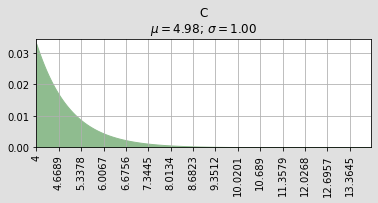
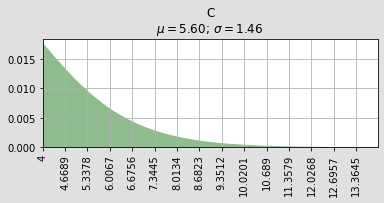
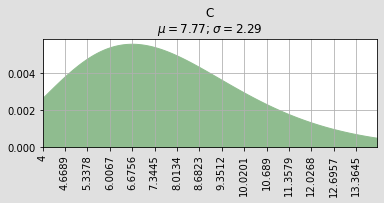
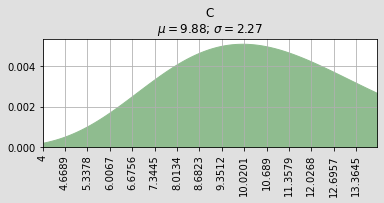

In [10]:
from scipy.stats import gamma
# cpt("C") is NB x NB matrix !
l=[]
for i in range(NB):
    k=(i*10.0)/NB
    l.append(normalize(gamma(k+1),4,14,NB))

bn.cpt("C")[:]=l

def showB(n:int):
    gnb.flow.add(gnb.getProba(bn.cpt("C").extract({"B":n})),
                 caption=f"P(C|B={bn.variable('B').label(n)})")
    
gnb.flow.clear()
showB(0)
showB(NB//4)
showB(NB*2//3)
showB(NB-1)
gnb.flow.display()

### Inference in quasi-continuous BN


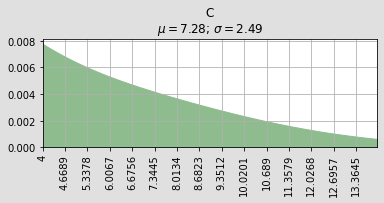

In [11]:
import time

ts = time.time()
ie=gum.LazyPropagation(bn)
ie.makeInference()
q=ie.posterior("C")
te=time.time()
gnb.flow.add(gnb.getPosterior(bn,target="C",evs={}),caption=f"P(C) computed in {te-ts:2.5f} sec for a model with {bn.dim()} paramters")
gnb.flow.display()


## Changing prior


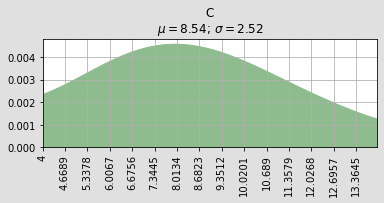

In [12]:
bn.cpt("A")[:]=[0.9,0.1]
             
gnb.flow.add(gnb.getPosterior(bn,target="C",evs={}),caption="P(C) with P(A)=[0.9,0.1]")
gnb.flow.display()

## inference with evidence in quasi-continuous BN

We want to compute 
<ul><li>
$P(A | C=9)$ 
</li><li>
$P(B | C=9)$
</li></ul>

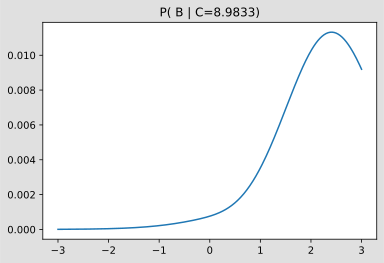

In [13]:
ie=gum.LazyPropagation(bn)
ie.setEvidence({'C':bn.variable("C").toNumericalDiscreteVar().closestLabel(9)})
ie.makeInference()
plot(linspace(minB,maxB,NB),ie.posterior("B")[:])
title("P( B | C={0})".format(bn.variable("C").toNumericalDiscreteVar().closestLabel(9)));

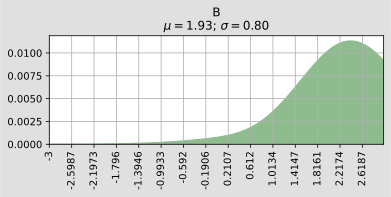

In [14]:
gnb.showPosterior(bn,target="B",evs={"C":bn.variable("C").toNumericalDiscreteVar().closestLabel(9)})

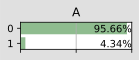

In [15]:
gnb.showProba(ie.posterior("A"))

## Multiple inference : MAP DECISION between Gaussian and generalized hyperbolic distributions

What is the behaviour of $P(A | C=i)$&nbsp;&nbsp; when $i$ varies ? I.e. we perform a MAP decision between the two models ($A=0$&nbsp; for the Gaussian distribution and $A=1$&nbsp; for the generalized hyperbolic  distribution).

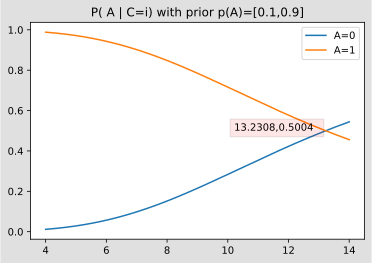

In [16]:
bn.cpt("A")[:]=[0.1, 0.9]
ie=gum.LazyPropagation(bn)
p0=[]
p1=[]
for i in bn.variable("C").labels():
    ie.setEvidence({'C':i})
    ie.makeInference()    
    p0.append(ie.posterior("A")[0])    
    p1.append(ie.posterior("A")[1])

x=[float(v) for v in bn.variable("C").labels()]
plot(x,p0)
plot(x,p1)
title("P( A | C=i) with prior p(A)=[0.1,0.9]")
legend(["A=0","A=1"],loc='best')
inters=(transpose(p0)<transpose(p1)).argmin()

text(x[inters]-0.2,p0[inters],
     "{0},{1:5.4f}  ".format(x[inters],p0[inters]),
     bbox=dict(facecolor='red', alpha=0.1),ha='right');

i.e. if $C<13.2308$ then $A=1$ else $A=0$

### Changing the prior $P(A)$

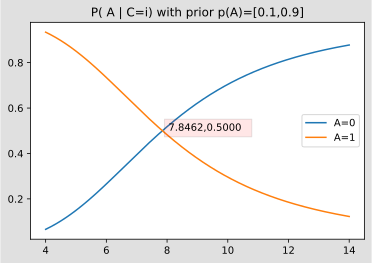

In [17]:
bn.cpt("A").fillWith([0.4, 0.6])
ie=gum.LazyPropagation(bn)
p0=[]
p1=[]
for i in range(300):
    ie.setEvidence({'C':i})
    ie.makeInference()    
    p0.append(ie.posterior("A")[0])    
    p1.append(ie.posterior("A")[1])
x=[float(v) for v in bn.variable("C").labels()]
plot(x,p0)
plot(x,p1)
title("P( A | C=i) with prior p(A)=[0.1,0.9]")
legend(["A=0","A=1"],loc='best')
inters=(transpose(p0)<transpose(p1)).argmin()

text(x[inters]+0.2,p0[inters],
     "{0},{1:5.4f}  ".format(x[inters],p0[inters]),
     bbox=dict(facecolor='red', alpha=0.1),ha='left');

ie. with $p(A)=[0.4,0.6]$, if $C<7.8462$ then $A=1$ else $A=0$.